## Importing Libraries

In [40]:
from glob import glob
import cv2
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.utils import normalize
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import load_model
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix

# connecting with kaggle dir

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manu0589","key":"781270b7f9a8d0e147c626ae65786ce8"}'}

In [3]:
! mkdir ~/.kaggle


In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria #download dataset from kaggle

 99% 666M/675M [00:02<00:00, 167MB/s]
100% 675M/675M [00:02<00:00, 262MB/s]


## Downloading Data 

In [8]:
import os
zip_path = '/content/cell-images-for-detecting-malaria.zip'

In [9]:
from zipfile import ZipFile
with ZipFile(zip_path,'r') as zip:
  zip.extractall()
  print('Done')

Done


### image visualization 

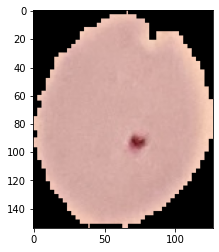

In [2]:
import matplotlib.pyplot as plt
im = plt.imread('/content/cell_images/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_180.png')
plt.imshow(im)
plt.show()

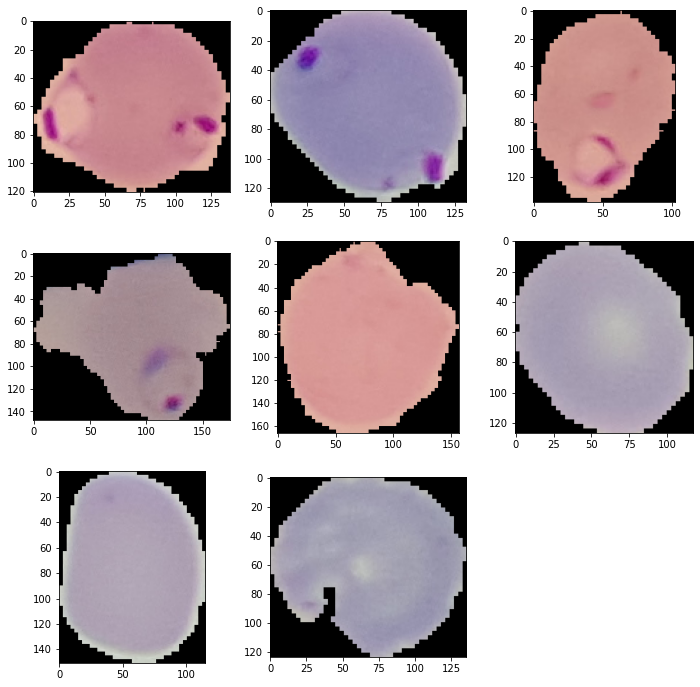

In [3]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
train_parasitized_fnames = os.listdir("/content/cell_images/Parasitized")
train_uninfected_fnames = os.listdir("/content/cell_images/Uninfected")
nrows = 3
ncols = 3
pic_index = 0
pic_index += 4
next_para_pix = [os.path.join("/content/cell_images/Parasitized", fname)
               for fname in train_parasitized_fnames[pic_index-4:pic_index]]
next_un_pix = [os.path.join("/content/cell_images/Uninfected", fname)
               for fname in train_uninfected_fnames[pic_index-4:pic_index]]
fig=plt.gcf()
fig.set_size_inches(ncols*4,nrows*4)
for i, img_path in enumerate(next_para_pix+next_un_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

### dividing data into train and test  

In [12]:
image_directory = '/content/cell_images/'
SIZE = 80
dataset = []    
label = []  


parasitized_images = os.listdir(image_directory + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):    
    
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)
        
uninfected_images = os.listdir(image_directory + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

In [13]:
dataset = np.array(dataset)
label = np.array(label)
print("Dataset size is ", dataset.shape)
print("Label size is ", label.shape)

Dataset size is  (27558, 80, 80, 3)
Label size is  (27558,)


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.30, random_state = 0)
print("Train size is ", X_train.shape)
print("Test size is ", X_test.shape)
print("Train size is ", y_train.shape)
print("Test size is ", y_test.shape)

Train size is  (19290, 80, 80, 3)
Test size is  (8268, 80, 80, 3)
Train size is  (19290,)
Test size is  (8268,)


In [15]:
print(y_train)

[1 1 0 ... 1 1 1]


In [16]:
X_train[0].ndim

3

In [17]:
n_classes = len(np.unique(y_train))
n_classes

2

In [18]:
X_train = np.array(X_train, dtype="float") / 255.0
X_test = np.array(X_test, dtype="float") / 255.0

In [19]:
X_train.shape

(19290, 80, 80, 3)

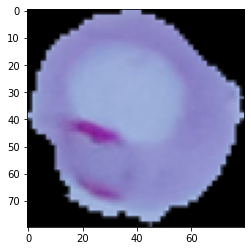

In [20]:
plt.imshow(X_train[100].squeeze())

## initializing cnn  model 

In [21]:
tf.keras.backend.clear_session()

In [22]:
INPUT_SHAPE = (SIZE, SIZE, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))  

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',             
              metrics=['accuracy'])

In [24]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        896       
                                                                 
 activation (Activation)     (None, 78, 78, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 37, 37, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                    

### training model 

In [25]:
history = model.fit(X_train, 
                         y_train, 
                         batch_size = 20, 
                         verbose = 1, 
                         epochs = 50,      
                         validation_data=(X_test,y_test)
                     )

Epoch 1/50
965/965 [==============================] - 20s 9ms/step - loss: 0.3457 - accuracy: 0.8459 - val_loss: 0.1497 - val_accuracy: 0.9569
Epoch 2/50
965/965 [==============================] - 8s 8ms/step - loss: 0.1642 - accuracy: 0.9514 - val_loss: 0.1337 - val_accuracy: 0.9594
Epoch 3/50
965/965 [==============================] - 8s 8ms/step - loss: 0.1469 - accuracy: 0.9552 - val_loss: 0.1226 - val_accuracy: 0.9611
Epoch 4/50
965/965 [==============================] - 8s 8ms/step - loss: 0.1348 - accuracy: 0.9573 - val_loss: 0.1243 - val_accuracy: 0.9591
Epoch 5/50
965/965 [==============================] - 9s 9ms/step - loss: 0.1273 - accuracy: 0.9582 - val_loss: 0.1225 - val_accuracy: 0.9590
Epoch 6/50
965/965 [==============================] - 8s 9ms/step - loss: 0.1183 - accuracy: 0.9611 - val_loss: 0.1220 - val_accuracy: 0.9594
Epoch 7/50
965/965 [==============================] - 8s 8ms/step - loss: 0.1080 - accuracy: 0.9641 - val_loss: 0.1289 - val_accuracy: 0.9539
Epoch

In [26]:
model.save('models/malaria_model_100epochs.h5') 

### visualization of training and validation loss and accuracy 

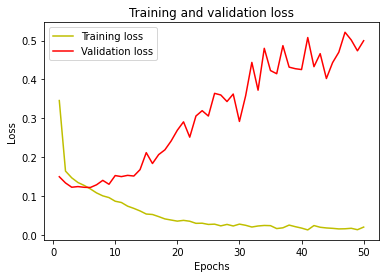

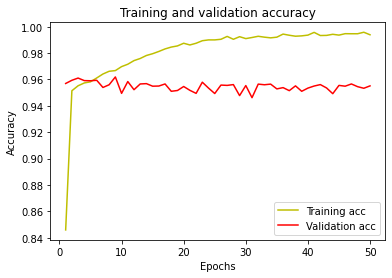

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Testing Model  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


The prediction for this image is:  [[3.0226164e-07 9.9999964e-01]]
The actual label for this image is:  1


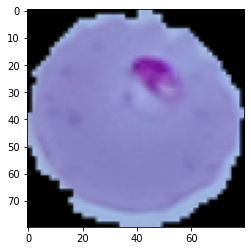

In [29]:
n=10  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", y_test[n])

In [29]:
from keras.models import load_model

### Accuracy and Confusion matrix 

In [30]:
model = load_model('models/malaria_model_100epochs.h5')

_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

259/259 [==============================] - 2s 6ms/step - loss: 0.4996 - accuracy: 0.9551
Accuracy =  95.51281929016113 %


In [31]:
mythreshold=0.885
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test)>= mythreshold).astype(int)
cm=confusion_matrix(y_test, y_pred)  
print(cm)

[[4034  140]
 [ 220 3874]]


## Using Pretrained model Resnet50 

In [4]:
image_directory = '/content/cell_images/'
SIZE = 80
image_data = []   
label1 = []  


parasitized_images = os.listdir(image_directory + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image_data.append(np.array(image))
        label1.append(1)
        
uninfected_images = os.listdir(image_directory + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image_data.append(np.array(image))
        label1.append(0)

In [5]:
image_data = np.array(image_data)
label1 = np.array(label1)
print("Dataset size is ", image_data.shape)
print("Label size is ", label1.shape)

Dataset size is  (27558, 80, 80, 3)
Label size is  (27558,)


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, Y_train, Y_test = train_test_split(image_data, label1, test_size = 0.30, random_state = 0)
print("Train size is ", x_train.shape)
print("Test size is ", x_test.shape)
print("Train size is ", Y_train.shape)
print("Test size is ", Y_test.shape)

Train size is  (19290, 80, 80, 3)
Test size is  (8268, 80, 80, 3)
Train size is  (19290,)
Test size is  (8268,)


In [7]:
n_classes = len(np.unique(Y_train))
n_classes

2

In [8]:
Y_train_onehot = tf.keras.utils.to_categorical(Y_train, num_classes= n_classes)
Y_test_onehot = tf.keras.utils.to_categorical(Y_test, num_classes= n_classes)

In [9]:
Y_train_onehot.shape

(19290, 2)

### Calling ResNet50 using weights imagenet 

In [10]:
tf.keras.backend.clear_session()
base = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
   
)


base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [11]:
base.trainable = False

base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [12]:
inputs = keras.Input(shape=(80, 80, 3))
x = base(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
out = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
model = keras.Model(inputs, out)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_____________________________________________

In [13]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [14]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('malaria_model_100epochs_Resnet50.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [17]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [18]:
history = model.fit(x_train, 
                         Y_train_onehot,
     steps_per_epoch=100,  
     epochs=10,
     validation_data=(x_test,Y_test_onehot),
     validation_steps=50,  
     verbose=2, callbacks=[model_checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.88909, saving model to malaria_model_100epochs_Resnet50.h5
100/100 - 36s - loss: 0.4260 - accuracy: 0.8394 - val_loss: 0.2796 - val_accuracy: 0.8891 - 36s/epoch - 363ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.88909 to 0.89695, saving model to malaria_model_100epochs_Resnet50.h5
100/100 - 33s - loss: 0.3113 - accuracy: 0.8773 - val_loss: 0.2520 - val_accuracy: 0.8970 - 33s/epoch - 331ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.89695 to 0.90542, saving model to malaria_model_100epochs_Resnet50.h5
100/100 - 34s - loss: 0.2777 - accuracy: 0.8918 - val_loss: 0.2426 - val_accuracy: 0.9054 - 34s/epoch - 339ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.90542 to 0.90953, saving model to malaria_model_100epochs_Resnet50.h5
100/100 - 34s - loss: 0.2602 - accuracy: 0.8980 - val_loss: 0.2286 - val_accuracy: 0.9095 - 34s/epoch - 335ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.90953 to 0.91

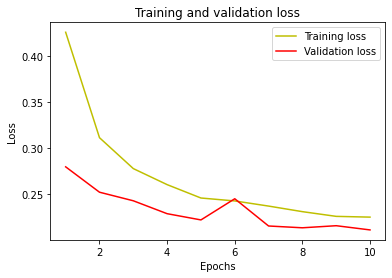

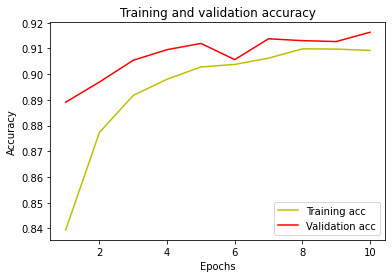

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


The prediction for this image is:  [[0.02093498 0.97906506]]
The actual label for this image is:  1


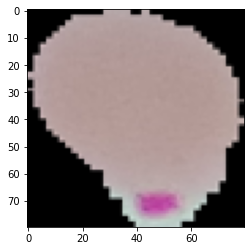

In [30]:
n=52  #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", Y_test[n])

In [35]:
model = load_model('/content/malaria_model_100epochs_Resnet50.h5')

#For 300 epochs, giving 82.5% accuracy

_, acc = model.evaluate(x_test, Y_test_onehot)
print("Accuracy = ", (acc * 100.0), "%")

  1/259 [..............................] - ETA: 23s - loss: 0.2719 - accuracy: 0.9375

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


259/259 [==============================] - 20s 77ms/step - loss: 0.2110 - accuracy: 0.9163
Accuracy =  91.6303813457489 %


In [45]:
mythreshold=0.885
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(x_test)>= mythreshold).astype(int)

cm=multilabel_confusion_matrix(Y_test_onehot, y_pred)  
print(cm)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[[[3946  148]
  [ 708 3466]]

 [[4000  174]
  [ 615 3479]]]
